In [1]:
import pandas as pd
import numpy as np
import os
import os.path as op
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import binarize
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#stuff for multiprocessing
from multiprocessing import Pool
from functools import partial
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd") # weird warning

#### Set directory to save simulated data & results

In [2]:
wd = op.join(os.getcwd(), 'simulation_data')
if not os.path.exists(wd):
    os.makedirs(wd)

### Function to create data

In [3]:
def create_dat(n_obs, n_ind, corr_independent_confound, corr_indep_dependent, seed=None):
    '''
    Generates a dataset, with the following properties:
    
    1. confound is a vector of random Gaussian numbers, of size n_obs (every participant has 1 value of the confound variable; e.g., brain size)
    2. X is a np.ndarray of size (n_obs, n_ind) containing the independent variables ("voxels")
    3. The independent variables ("voxels") are correlated with the confound (brain size)
    4. The independent variables ("voxels") are correlated with the dependent variable y
    5. y is a continuous dependent variable (e.g., 'intelligence')
    
    Parameters
    -------------
    n_obs : int
        Number of participants (observations)
    n_ind : int
        Number of independent variables ("voxels")
    corr_independent_confound : float
        Value determining the strength of the correlation between the independent variables ("voxels") and confound. Higher = stronger correlations possible. Note that correlations are 'random'; not all independent variables correlate with the confound.
    corr_independent_dependent : float
        Value determining the strength of the correlation between the independent variables and the dependent variable.
    seed : int
        Seed for replicability
        
    Returns
    -------------
    data : dict
        Dictionary with four keys: X, y, confound, and weights. X is a numpy ndarray of size (n_obs, n_ind); y is of size (n_obs,1); confound is of size (n_obs,); weights is a np.ndarray of size (n_ind,)
    '''
    
    if seed:
        np.random.seed(seed)
    
    confound = np.random.normal(size=n_obs) # simulate normalized brain size
    data = np.ndarray(shape=(n_obs, n_ind))   # empty ndarray

    # Generate n_ind independent variables. Each independent variable is the brain size multiplied by 
    # some random gaussian value (mean 0 std 1), with gaussian noise
    for x_i in np.arange(n_ind):
        conf_weight = np.abs(np.random.normal(0, corr_independent_confound)) # This assumes that the correlation between IVs and the confound is identical for all observations (fixed effects). For random effects, add some gaussian noise here.
#         print(bs_weight)
        data[:,x_i] = confound*conf_weight + np.random.normal(size=n_obs)
    
    # Weights (betas) that specify the relation between each independent var and the dep var. Also random normal (mean 0, std 1)
    weights = np.random.normal(0, corr_indep_dependent, size=n_ind) # Assumes fixed effects for relation IVs and DV. For random effects, add Gaussian noise.
    
    # y is defined as weights * data plus random noise
    y = np.dot(data, weights) + np.random.normal(size=n_obs)
    y = y.reshape(y.shape[0], 1)
    
    out = {'X':data, 'y':y, 'confound':confound, 'weights' : weights}
    return out

#### Function to 'regress out' or 'partial out' variance explained by a confound from all independent vars

In [4]:
def regress_out_confound(X, conf):
    '''
    Regresses out confounds from a matrix of independent vars
    '''
        
    for x_i in np.arange(X.shape[1]):
        mod = LinearRegression().fit(X=conf.reshape(-1,1), y=X[:,x_i].reshape(-1,1))
        
        preds = mod.predict(conf.reshape(-1,1))
        preds = preds.reshape((preds.shape[0],))
        X[:,x_i] = X[:,x_i] - preds
        
    return X

#### ML-routine

In [5]:
class Clf(object):
    '''
    K-fold cross-validation routine: learns weights on train data, predicts & scores test data. 
    Returns a vector of n_folds accuracies. Defaults to 10 folds.
    '''
    
    def __init__(self, X, y, n_splits=10):
        self.X = X
        self.y = y
        self.folds = KFold(n_splits=n_splits)
        self.acc = np.ndarray(n_splits)
        self.weights = np.ndarray((n_splits, X.shape[1]))

    def train_fit(self):
        X = self.X
        y = self.y
        for i, (train_idx, test_idx) in enumerate(self.folds.split(X)):
            X_train = X[train_idx,:]
            y_train = y[train_idx]
            X_test = X[test_idx,:]
            y_test = y[test_idx]

            mod = LogisticRegression().fit(X=X_train, y=y_train)
            self.acc[i] = mod.score(X=X_test, y=y_test)   
            self.weights[i,:] = mod.coef_
        
        return self

### Process function for multiprocessing

In [6]:
def process(dataset_n, n_obs, n_ind, corr_independent_confound, corr_indep_dependent, regress_confound=True, plot=True, verbose=False, save_dir=None):
    
    # Generate data
    data = create_dat(120, n_ind, corr_independent_confound, corr_indep_dependent, dataset_n)
    
    if regress_confound:
        # Regress out brain size from X
        data_orig = deepcopy(data)
        data['X'] = regress_out_confound(X=data['X'], conf=data['confound'])
    
    # Binarize y
    y2 = binarize(data['y'], threshold=np.median(data['y']))
    y2 = np.ravel(y2)
    
    # Perform K-fold crossvalidation
    clf = Clf(X=data['X'], y=y2, n_splits=10)
    clf.train_fit()
    mean_acc = np.mean(clf.acc)
    coefs = np.mean(clf.weights, axis=0)
    
#     print(coefs)
    
    if plot:
        plot_data(data_orig, no_conf=data['X'], coefs=coefs, save_dir=save_dir, _id=dataset_n)
    
    if verbose:
        print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, dataset %d, accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, dataset_n, mean_acc))

    return mean_acc

#### Some minor visualisations
Checks & Balances for data generation:

What does the data look like when we colorcode them? How about the correlation matrix; and does to correlation between y and each independent variable correspond to the weights?

In [7]:
def plot_data(data, no_conf=None, coefs=None, save_dir=None, _id=None):
    '''
    Makes some plots of data.
    '''
    
    #Set some plotting settings
    sns.set(context="paper", font="monospace")

    # Set-up figure, axes
    f, axes = plt.subplots(2,3)
    f.set_figheight(15)
    f.set_figwidth(15)

    # Plot 1: actual data
    df = pd.DataFrame(data['X'])
    sns.heatmap(df, ax=axes[0,0])
    axes[0,0].set_title('Raw data colorized')

    # Plot 2: correlation matrix of IVs, DV, and confound
    df['confound'] = data['confound']
    df['y'] = data['y']

    sns.heatmap(df.corr(), ax=axes[0,1])
    axes[0,1].set_title('Correlation matrix IVs, confound, DV')

    # Plot 3: Actual weights, colorized. The colors should roughly correspond to the correlation between y and each IV.
    sns.heatmap(pd.DataFrame(data['weights']).transpose(), ax=axes[0,2])
    axes[0,2].set_title('Weights colorized')

    # Plot 4: Data with variance explained by the confound regressed out.
    nc = pd.DataFrame(no_conf)

    sns.heatmap(nc, ax=axes[1,0])
    axes[1,0].set_title('Data after removing confound, colorized')

    # Plot 5: Correlation matrix after regressing out confound
    nc['confound'] = data['confound']
    nc['y'] = data['y']
    sns.heatmap(nc.corr(), ax=axes[1,1])
    axes[1,1].set_title('Correlation matrix NC IVs, confound, DV')

    # Plot 6: fitted estimates of weights. NOTE: DOES NOT NECESSARILY MAKE SENSE FOR LOGISTIC REG!
    sns.heatmap(pd.DataFrame(coefs).transpose(), ax=axes[1,2])
    axes[1,2].set_title('Fitted coefficients')
    
    if save_dir:
        f.savefig(op.join(save_dir, "dataset %d.pdf") %(_id), bbox_inches='tight')

### Processing
Multiprocessed 'grid search'. For various numbers of IVs, various strengths of correlations between the IV and confound, various strengths of correlation between IVs&DV, do the following:
1. Generate 10 random data sets
2. Perform 10-fold cross-validation for each data set individually
3. Return mean accuracy over 10 folds per dataset
4. Average the 10 mean accuracies in a final "mean accuracy", which is returned and printed. If this value is below 0.5, we replicated the "below-chance accuracy"-issue.

In [ ]:
verbose=True
#for n_ind in [2, 5, 10, 100, 1000, 5000]:
for n_ind in [1000, 5000]:
    for corr_independent_confound in [0, .1, 1, 2, 5]:
        for corr_indep_dependent in [0, .1, 1, 2, 5]:
            
            saving_dir = op.join(wd, 'n_ind_' + str(n_ind), 'corr_IV_conf_' + str(corr_independent_confound), 'corr_IV_DV_' + str(corr_indep_dependent))
            if not os.path.exists(saving_dir):
                os.makedirs(saving_dir)

#             process(1, n_obs=120, n_ind=n_ind, corr_independent_confound=corr_independent_confound, corr_indep_dependent=corr_indep_dependent, plot=True, verbose=verbose)
            n_datasets = 10
            p = Pool(4)
            res = p.map(partial(process, n_obs=120, n_ind=n_ind, corr_independent_confound=corr_independent_confound, corr_indep_dependent=corr_indep_dependent, plot=True, verbose=verbose, save_dir=saving_dir), np.arange(n_datasets))
            p.close()
            p.join()
            print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, mean accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, np.mean(res)))
            
            # Write results to file
            with open(op.join(saving_dir,'mean_acc.txt'), 'w') as f:
                for item in res:
                    f.write("%s\n" % item)
                
                f.write('\nMean accuracy over the above datasets:\n')
                f.write(str(np.mean(res)))

## old stuff below

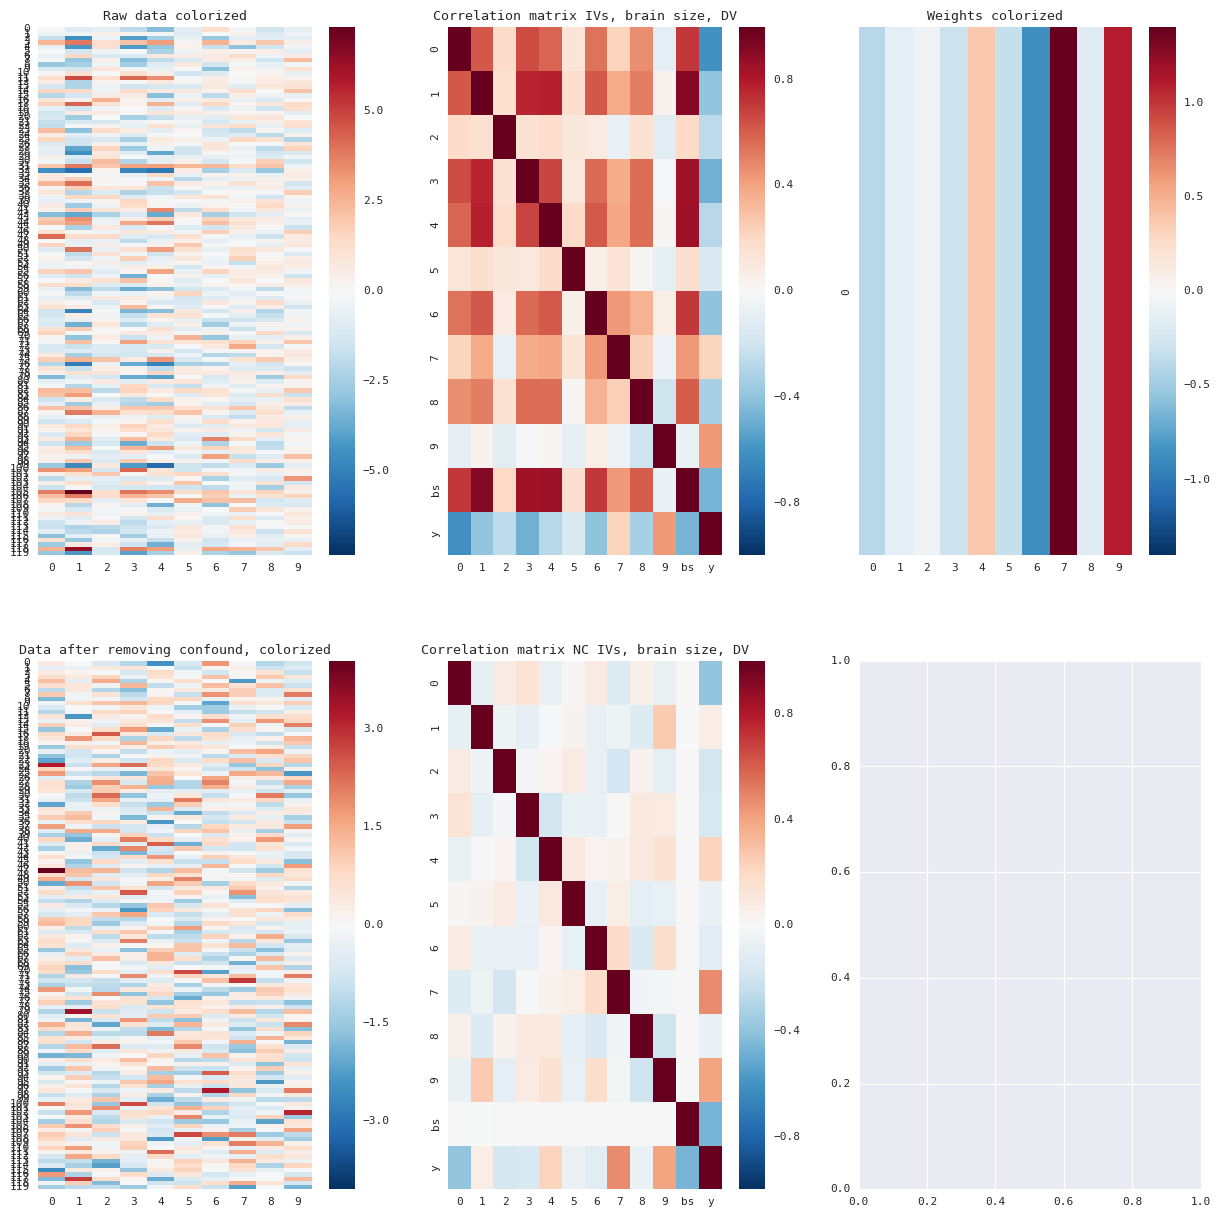

In [8]:
data = create_dat(120, 10, 1, 1, 2)
nc = regress_out_confound(deepcopy(data['X']), data['brain_size'])
plot_data(data, nc)

In [9]:
verbose=False

for n_ind in [100, 1000, 5000]:
    for corr_independent_confound in [0, .1, .5, 1, 2, 5, 10]:
        for corr_indep_dependent in [0, .1, .5, 1, 2, 5, 10]:
            
            saving_dir = op.join(wd, 'n_ind_' + str(n_ind), 'corr_IV_conf_' + str(corr_independent_confound), 'corr_IV_DV_' + str(corr_indep_dependent))
            if not os.path.exists(saving_dir):
                os.makedirs(saving_dir)

            n_datasets = 10
            p = Pool(4)
            res = p.map(partial(process, n_obs=120, n_ind=n_ind, corr_independent_confound=corr_independent_confound, corr_indep_dependent=corr_indep_dependent, plot=True, verbose=verbose), np.arange(n_datasets))
            p.close()
            p.join()
            print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, mean accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, np.mean(res)))
            
            # Write results to file
            with open(op.join(saving_dir,'mean_acc.txt'), 'w') as f:
                for item in res:
                    f.write("%s\n" % item)
                
                f.write('\n')
                f.write(str(np.mean(res)))

Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 0.00, mean accuracy: 0.505
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 0.10, mean accuracy: 0.622
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 0.50, mean accuracy: 0.745
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 1.00, mean accuracy: 0.748
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 2.00, mean accuracy: 0.736
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 5.00, mean accuracy: 0.732
Settings: n_ind = 100, corr_independent_confound = 0.00, corr_indep_dependent = 10.00, mean accuracy: 0.727
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 0.00, mean accuracy: 0.505
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 0.10, mean accuracy: 0.622
Settings: n_ind = 100, corr_independ